In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
from itertools import combinations
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima.model import ARIMA as ARIMA
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_predict
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [ ]:
# Read the data
df = pd.read_csv('/content/NETFLIX dataset AIML.csv')

In [ ]:
# Head of data
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,05-02-2018,262.000000,267.899994,250.029999,254.259995,254.259995,11896100
1,06-02-2018,247.699997,266.700012,245.000000,265.720001,265.720001,12595800
2,07-02-2018,266.579987,272.450012,264.329987,264.559998,264.559998,8981500
3,08-02-2018,267.079987,267.619995,250.000000,250.100006,250.100006,9306700
4,09-02-2018,253.850006,255.800003,236.110001,249.470001,249.470001,16906900


In [ ]:
# tail of data
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
1004,31-01-2022,401.970001,427.700012,398.200012,427.140015,427.140015,20047500
1005,01-02-2022,432.959991,458.480011,425.540009,457.130005,457.130005,22542300
1006,02-02-2022,448.250000,451.980011,426.480011,429.480011,429.480011,14346000
1007,03-02-2022,421.440002,429.260010,404.279999,405.600006,405.600006,9905200
1008,04-02-2022,407.309998,412.769989,396.640015,410.170013,410.170013,7782400


Data Cleaning

In [ ]:
# Info of data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1009 entries, 0 to 1008
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1009 non-null   object 
 1   Open       1009 non-null   float64
 2   High       1009 non-null   float64
 3   Low        1009 non-null   float64
 4   Close      1009 non-null   float64
 5   Adj Close  1009 non-null   float64
 6   Volume     1009 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 55.3+ KB


From the info above we know that there is no missing values in the data

In [ ]:
# Convert date datatype into datetime
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')


In [ ]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-02-05,262.000000,267.899994,250.029999,254.259995,254.259995,11896100
1,2018-02-06,247.699997,266.700012,245.000000,265.720001,265.720001,12595800
2,2018-02-07,266.579987,272.450012,264.329987,264.559998,264.559998,8981500
3,2018-02-08,267.079987,267.619995,250.000000,250.100006,250.100006,9306700
4,2018-02-09,253.850006,255.800003,236.110001,249.470001,249.470001,16906900


EDA-Exploratory Data Analysis

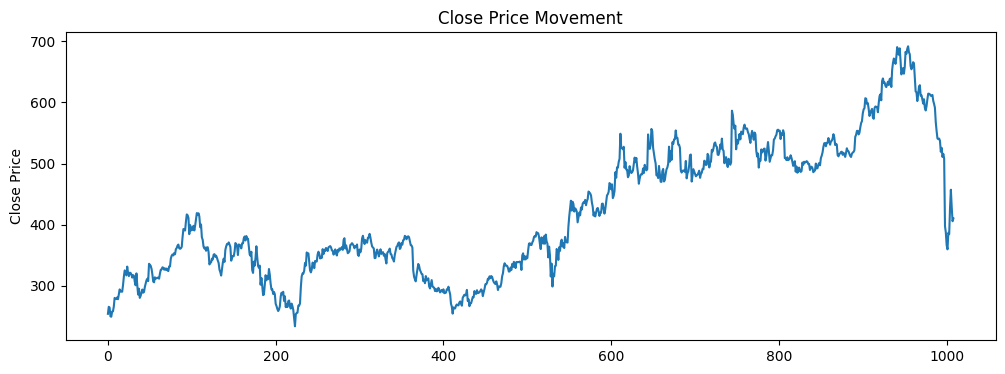

In [ ]:
# plot the close price
df['Close'].plot(title="Close Price Movement", ylabel="Close Price", figsize=(12,4));

From the plot above,seems like there is some trend and seasonality

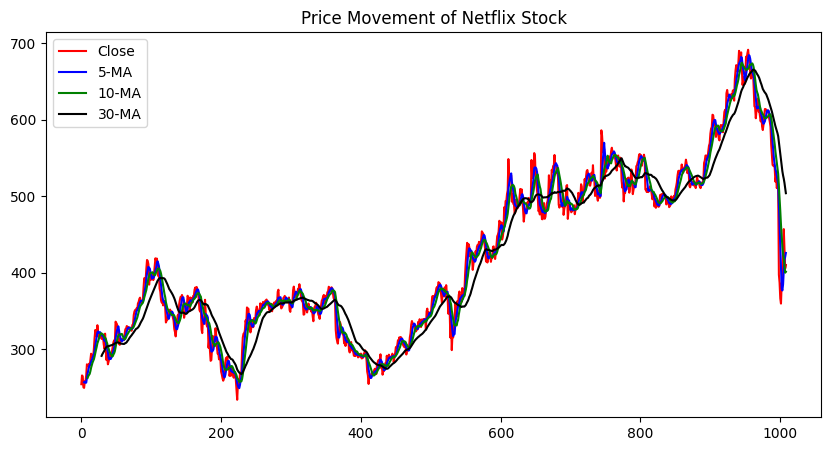

In [ ]:
# adding 5, 10, 30 MA
df["5_ma"] = df["Close"].rolling(5).mean()
df["10_ma"] = df["Close"].rolling(10).mean()
df["30_ma"] = df["Close"].rolling(30).mean()

# plot the price with the moving average
plt.subplots(figsize=(10, 5))
plt.plot(df["Close"], color="red", label="Close")
plt.plot(df["5_ma"], color="blue", label="5-MA")
plt.plot(df["10_ma"], color="green", label="10-MA")
plt.plot(df["30_ma"], color="black", label="30-MA")
plt.title("Price Movement of Netflix Stock")
plt.legend()
plt.show()

The pattern of price movement is the same even with the Moving Average (MA). The longer MA period, the price movement become smoother

All the price movement has the same pattern

In [ ]:
# date when close price is the highest
df[df["Close"] == max(df["Close"])]

,Date,Open,High,Low,Close,Adj Close,Volume,5_ma,10_ma,30_ma
954,2021-11-17,690.0,700.98999,686.090027,691.690002,691.690002,2732800,679.722009,666.708002,657.00366


In [ ]:
# date when close price is the lowest
df[df["Close"] == min(df["Close"])]

,Date,Open,High,Low,Close,Adj Close,Volume,5_ma,10_ma,30_ma
223,2018-12-24,242.0,250.649994,233.679993,233.880005,233.880005,9547600,255.711996,262.441997,273.561


In [ ]:
# date when close price same as adj close
df[df["Close"] == df["Adj Close"]]

,Date,Open,High,Low,Close,Adj Close,Volume,5_ma,10_ma,30_ma
0,2018-02-05,262.000000,267.899994,250.029999,254.259995,254.259995,11896100,NaN,NaN,NaN
1,2018-02-06,247.699997,266.700012,245.000000,265.720001,265.720001,12595800,NaN,NaN,NaN
2,2018-02-07,266.579987,272.450012,264.329987,264.559998,264.559998,8981500,NaN,NaN,NaN
3,2018-02-08,267.079987,267.619995,250.000000,250.100006,250.100006,9306700,NaN,NaN,NaN
4,2018-02-09,253.850006,255.800003,236.110001,249.470001,249.470001,16906900,256.822000,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1004,2022-01-31,401.970001,427.700012,398.200012,427.140015,427.140015,20047500,384.864007,424.388000,527.323000
1005,2022-02-01,432.959991,458.480011,425.540009,457.130005,457.130005,22542300,403.006006,419.021002,523.003001
1006,2022-02-02,448.250000,451.980011,426.480011,429.480011,429.480011,14346000,416.962006,410.383005,517.527668
1007,2022-02-03,421.440002,429.260010,404.279999,405.600006,405.600006,9905200,420.742004,400.118005,510.883669


In [ ]:
# date with the busiest trade
df[df["Volume"] == max(df["Volume"])]

,Date,Open,High,Low,Close,Adj Close,Volume,5_ma,10_ma,30_ma
998,2022-01-21,400.429993,409.149994,379.98999,397.5,397.5,58904300,491.619995,513.626996,570.98433


In [ ]:
# date with the least trade
df[df["Volume"] == min(df["Volume"])]

,Date,Open,High,Low,Close,Adj Close,Volume,5_ma,10_ma,30_ma
728,2020-12-24,515.119995,519.349976,512.210022,513.969971,513.969971,1144000,523.827991,522.229001,501.993667


Function for time series analysis

In [ ]:
def test_stationarity(timeseries, n_roll):
    #Determing rolling statistics
    MA = timeseries.rolling(window=n_roll).mean()
    MSTD = timeseries.rolling(window=n_roll).std()

    #Plot rolling statistics:
    plt.figure(figsize=(15,5))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(MA, color='red', label='Rolling Mean')
    std = plt.plot(MSTD, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    # Duckey-Fuller test:
    print('Duckey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)


In [ ]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)

    with plt.style.context(style):
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

Decomposing the data:
The close price data will be decomposed to explore more about the close price movement. The model used is additive because the close price movement show additive model

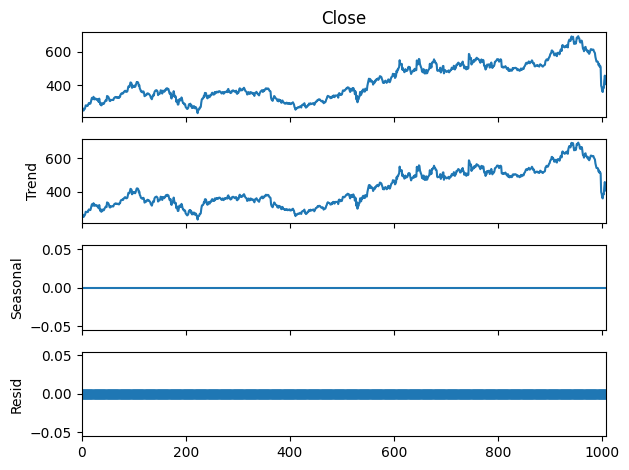

In [ ]:
# decompose the close component with period 1
seasonal_decompose(df['Close'], period = 1, model = 'additive').plot();

As we see that the close price does not have seasonal component and the residuals are 0

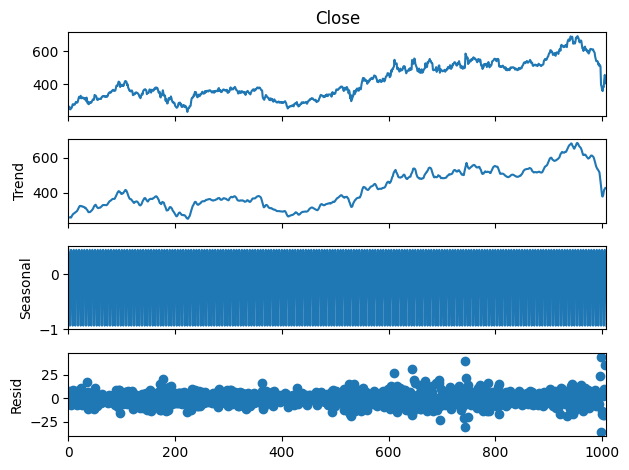

In [ ]:
# decompose the close component with period 5
seasonal_decompose(df['Close'], period = 5, model = 'additive').plot();

As we see that the close price has seasonal component and the residuals are between -25 to 25

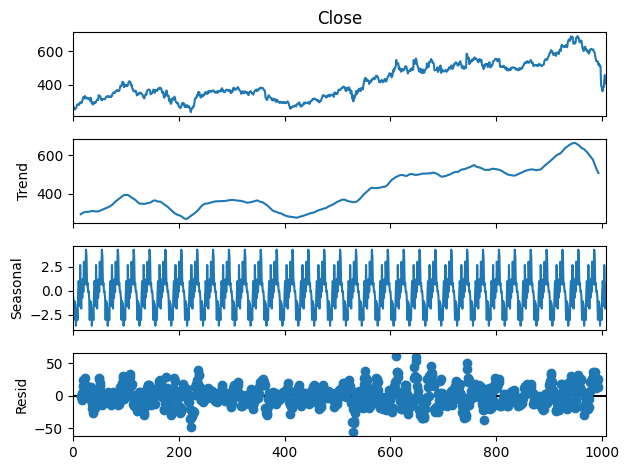

In [ ]:
# decompose the close component with period 30
seasonal_decompose(df['Close'], period = 30, model = 'additive').plot();

As we see that the close price has seasonal component and the residuals are between -50 to 50

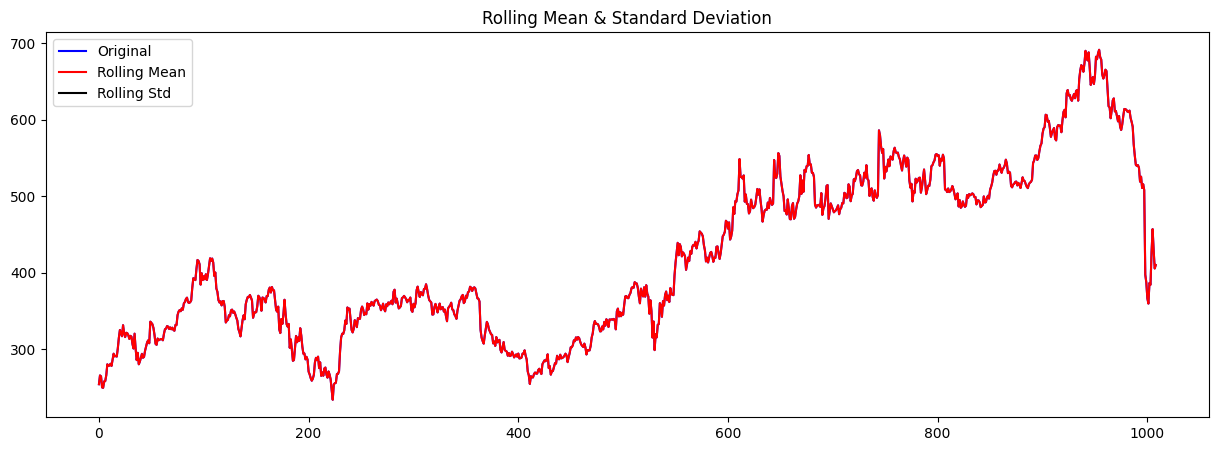

Duckey-Fuller Test:
Test Statistic                   -1.812591
p-value                           0.374229
#Lags Used                        6.000000
Number of Observations Used    1002.000000
Critical Value (1%)              -3.436893
Critical Value (5%)              -2.864429
Critical Value (10%)             -2.568308
dtype: float64


In [ ]:
test_stationarity(df['Close'], n_roll=1)

Because the p-value = 0.37 > 0.05, so we conclude that data is not stationary. To make it stationary, we need to do differencing

Modelling with LSTM:
In this section the LSTM model (deep learning model) will be used. I use this to learn more about lstm for forecasting

In [ ]:
# defining train and test size
dataset = pd.DataFrame(df.reset_index()["Close"])
data = dataset.values
data = data.astype('float32')

# scaling the data into range (0, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data)

# fix random seed for reproducibility
tf.random.set_seed(1)

# train and test size
train_size = int(len(data)*0.7)
test_size = len(data)-train_size
train, test = data[0:train_size,:], data[train_size:len(data),:]
print(len(train), len(test))

706 303


In [ ]:
# function to take
def create_dataset(dataset, look_back=1):
 dataX, dataY = [], []
 for i in range(len(dataset)-look_back-1):
     a = dataset[i:(i+look_back), 0]
     dataX.append(a)
     dataY.append(dataset[i + look_back, 0])
 return np.array(dataX), np.array(dataY)

# train and test set
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# reshape the X and y data
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [ ]:
# fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
704/704 - 4s - loss: 0.0473 - 4s/epoch - 5ms/step
Epoch 2/100
704/704 - 2s - loss: 0.0248 - 2s/epoch - 2ms/step
Epoch 3/100
704/704 - 1s - loss: 0.0195 - 1s/epoch - 2ms/step
Epoch 4/100
704/704 - 1s - loss: 0.0071 - 1s/epoch - 2ms/step
Epoch 5/100
704/704 - 1s - loss: 6.6899e-04 - 1s/epoch - 2ms/step
Epoch 6/100
704/704 - 1s - loss: 5.1074e-04 - 1s/epoch - 2ms/step
Epoch 7/100
704/704 - 1s - loss: 5.0794e-04 - 1s/epoch - 2ms/step
Epoch 8/100
704/704 - 1s - loss: 5.1098e-04 - 1s/epoch - 2ms/step
Epoch 9/100
704/704 - 1s - loss: 5.0780e-04 - 1s/epoch - 2ms/step
Epoch 10/100
704/704 - 1s - loss: 5.0715e-04 - 1s/epoch - 2ms/step
Epoch 11/100
704/704 - 1s - loss: 5.0111e-04 - 1s/epoch - 2ms/step
Epoch 12/100
704/704 - 2s - loss: 5.0554e-04 - 2s/epoch - 2ms/step
Epoch 13/100
704/704 - 1s - loss: 5.0529e-04 - 1s/epoch - 2ms/step
Epoch 14/100
704/704 - 1s - loss: 5.0806e-04 - 1s/epoch - 2ms/step
Epoch 15/100
704/704 - 1s - loss: 4.9817e-04 - 1s/epoch - 2ms/step
Epoch 16/100
704/704

In [ ]:
# predict the close price
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# invert predictions so the unit became range of the close price range
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

10/10 [==============================] - 1s 2ms/step
Train Score: 10.30 RMSE
Test Score: 24.27 RMSE


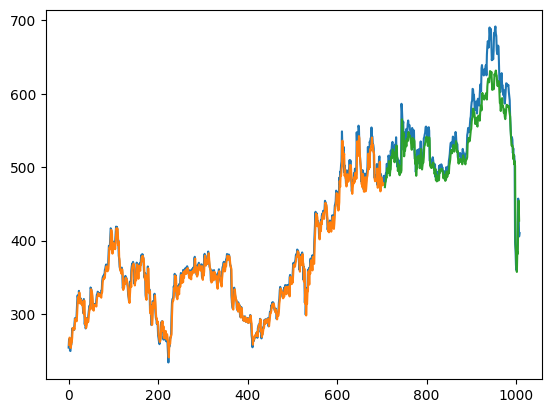

In [ ]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(data)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(data)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(data)-1, :] = testPredict

# plot baseline and predictions
plt.plot(scaler.inverse_transform(data))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

From the plot above we could see that the LSTM is a very good model to predict the Netflix Close price. The movement of the model and the base price is the same. Besides, the Test Score RMSE is in range of 20-30 (23.42) is a small value because compared to the range of close price which is 200-600.

In [14]:
#develop stock price prediction model using Linear Regression
lr_model=LinearRegression()
#fit the training set to train the model
lr_model.fit(X_train,y_train)
#predict using test set
lr_predict = lr_model.predict(X_test)
#show daily prediction of adjusted close price
print(lr_predict)

[4.]


In [18]:
from sklearn.neighbors import KNeighborsRegressor

In [12]:
from sklearn.neighbors import KNeighborsRegressor

# Assuming you have X_train, X_test, y_train, and y_test defined

# Decrease the number of neighbors to a value smaller than the number of samples in your training set
knn_regressor = KNeighborsRegressor(n_neighbors=3)  # Adjust the number of neighbors as needed
knn_model = knn_regressor.fit(X_train, y_train)
knn_pred = knn_model.predict(X_test)
print(knn_pred)


[5.33333333]
